In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam


2024-04-08 08:56:02.041202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 08:56:02.041258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 08:56:02.042950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Normalize data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5




In [3]:
from tensorflow.keras.utils import to_categorical

num_classes=10
y_train_one_hot = to_categorical(Y_train, num_classes)
y_test_one_hot=to_categorical(Y_test, num_classes)


In [4]:
def build_generator(latent_dim):
    model = Sequential([
        Dense(4 * 4 * 256, input_dim=latent_dim),
        Reshape((4, 4, 256)),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(3, (3, 3), activation='tanh', padding='same')
    ])
    return model


In [5]:
from tensorflow.keras.layers import Dense, Flatten, Concatenate

# Define discriminator model
def build_discriminator(input_shape, num_classes):
    image_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(image_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    
    # Binary classification output
    validity_output = Dense(1, activation='sigmoid')(x)
    
    # Class label prediction output
    class_label_output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=image_input, outputs=[validity_output, class_label_output])
    return model


In [6]:
# Define the combined generator and discriminator model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([
        generator,
        discriminator
    ])
    return model


In [7]:
def custom_discriminator_loss(y_true, y_pred):
    # Binary cross-entropy loss for validity output
    validity_loss = binary_crossentropy(y_true[0], y_pred[0])
    
    # Categorical cross-entropy loss for class label output
    class_label_loss = categorical_crossentropy(y_true[1], y_pred[1])
    
    # Combine the losses
    total_loss = validity_loss + class_label_loss
    
    return total_loss


In [8]:
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
# Define parameters
latent_dim = 100
input_shape = X_train[0].shape

# Build and compile the discriminator
discriminator = build_discriminator(input_shape,10)
# Compile the discriminator model with two metrics
discriminator.compile(loss=custom_discriminator_loss,
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy', 'accuracy'])  # Add 'accuracy' for both outputs

# Build the generator
generator = build_generator(latent_dim)

# Build and compile the combined model
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Training loop
epochs = 80
batch_size = 32
batch_count = 256 // batch_size



/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Lists to store losses
discriminator_losses = []
generator_losses = []

for epoch in range(epochs):
    for batch in range(batch_count):
        # Train discriminator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

        discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
        discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        discriminator_loss = 0.5 * np.add(discriminator_loss_fake, discriminator_loss_real)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Print losses
        print(f'Epoch: {epoch + 1}, Batch: {batch + 1}/{batch_count}, '
              f'[Discriminator Loss: {discriminator_loss[0]}, Accuracy: {100 * discriminator_loss[1]}] '
              f'[Generator Loss: {generator_loss}]')
        
    # Store losses at the end of each epoch
    discriminator_losses.append(discriminator_loss[0])
    generator_losses.append(generator_loss)
    
    # Optionally, you can print average losses for the epoch
    print(f'Epoch {epoch + 1} average losses: [Discriminator Loss: {np.mean(discriminator_losses)}, Generator Loss: {np.mean(generator_losses)}]')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1712566597.665334   21413 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/tmp/ipykernel_21371/246126702.py:6: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(1,). Consider using 'binary_crossentropy' if you only have 2 classes.
  class_label_loss = categorical_crossentropy(y_true[1], y_pred[1])
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 1, Batch: 1/8, [Discriminator Loss: 0.6837369203567505, Accuracy: 43.75] [Generator Loss: 0.6592331528663635]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch: 1, Batch: 2/8, [Discriminator Loss: 0.6673668622970581, Accuracy: 45.44270932674408] [Generator Loss: 0.6580114364624023]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch: 1, Batch: 3/8, [Discriminator Loss: 0.6678023338317871, Accuracy: 44.479167461395264] [Generator Loss: 0.6540873050689697]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch: 1, Batch: 4/8, [Discriminator Loss: 0.6757510304450989, Accuracy: 42.80133843421936] [Generator Loss: 0.6482219696044922]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch: 1, Batch: 5/8, [Discriminator Loss: 0.676713228225708, Accuracy: 41.21527671813965] [Generator Loss: 0.6365403532981873]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch: 1, Batch: 6/8, [Discriminator Loss: 0.6774965524673462, Accuracy: 40.16335308551788] [Generator Loss: 0.6291863918304443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch: 1, 

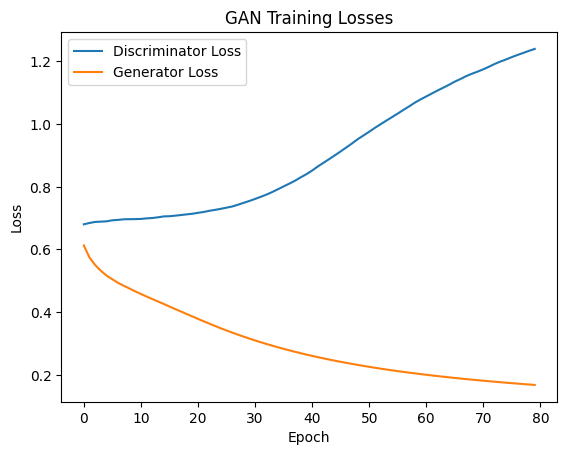

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Plot losses
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


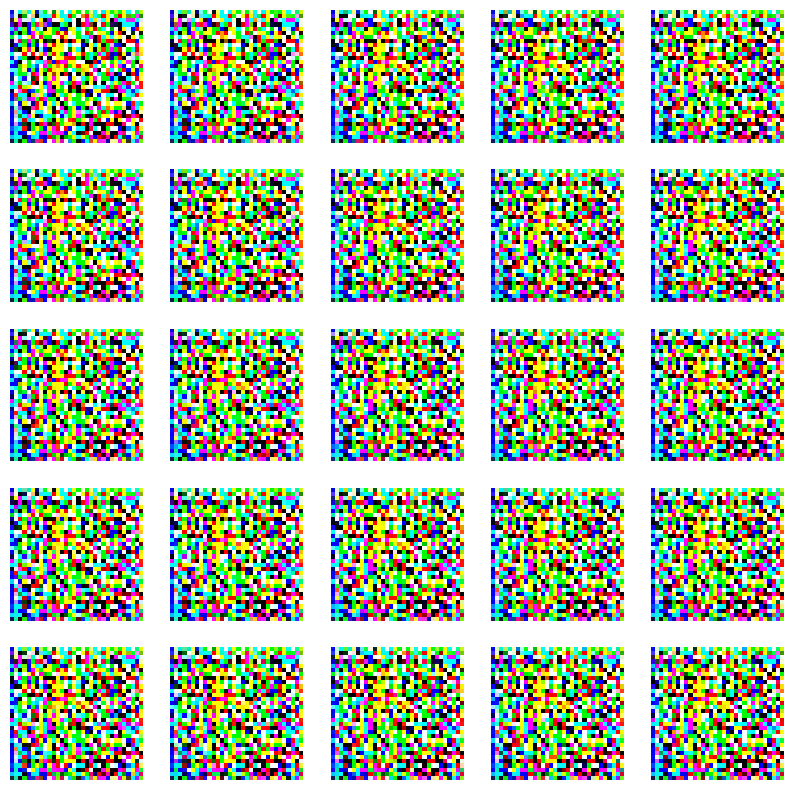

In [11]:
# Save generated images and pass them to discriminator for classification
if (epoch + 1) % 10 == 0:
    noise = np.random.normal(0, 1, (25, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5
    
    # Display generated images
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()
    
    

In [12]:
import numpy as np

# Assuming you have defined 'latent_dim' somewhere in your code
latent_dim = 100

# Generate noise for 25 samples
noise = np.random.normal(0, 1, (25, latent_dim))
generated_images = generator.predict(noise)

# Get discriminator's predictions for the generated images
discriminator_predictions = discriminator.predict(generated_images)

print(discriminator_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
[array([[0.9538653 ],
       [0.9528265 ],
       [0.9523438 ],
       [0.95342386],
       [0.9535934 ],
       [0.95371926],
       [0.95312554],
       [0.95343447],
       [0.9535537 ],
       [0.9525981 ],
       [0.9530215 ],
       [0.9535837 ],
       [0.95290256],
       [0.95310426],
       [0.95387423],
       [0.95401645],
       [0.95383525],
       [0.9527571 ],
       [0.952313  ],
       [0.95430195],
       [0.9536936 ],
       [0.95312965],
       [0.9535865 ],
       [0.9532658 ],
       [0.95371217]], dtype=float32), array([[0.11393312, 0.10717789, 0.09452085, 0.10339274, 0.10097495,
        0.08317142, 0.10035495, 0.11358426, 0.0829841 , 0.09990568],
       [0.11484464, 0.10690463, 0.09646772, 0.09917983, 0.10262668,
        0.0840656 , 0.10002416, 0.11138944, 0.08380814, 0.10068925],
       [0.11389817, 0.10949674, 0.09417906, 0.0999966 , 0.10144616,
        0.08176897, 0.10309794, 0.1107

W0000 00:00:1712567135.976630   21416 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [13]:
threshold = 0.5  # Set the threshold for discriminator's output

# Convert discriminator predictions to binary labels (real/fake)
binary_labels = ['Real' if pred >= threshold else 'Fake' for pred in discriminator_predictions[0]]

# Convert class probabilities to class labels
class_labels = [np.argmax(prob) for prob in discriminator_predictions[1]]

# Print the converted labels
print("Binary labels (Real/Fake):", binary_labels)
print("Class labels:", class_labels)

Binary labels (Real/Fake): ['Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real']
Class labels: [0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 7, 7, 0, 7, 0, 7, 0, 0, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


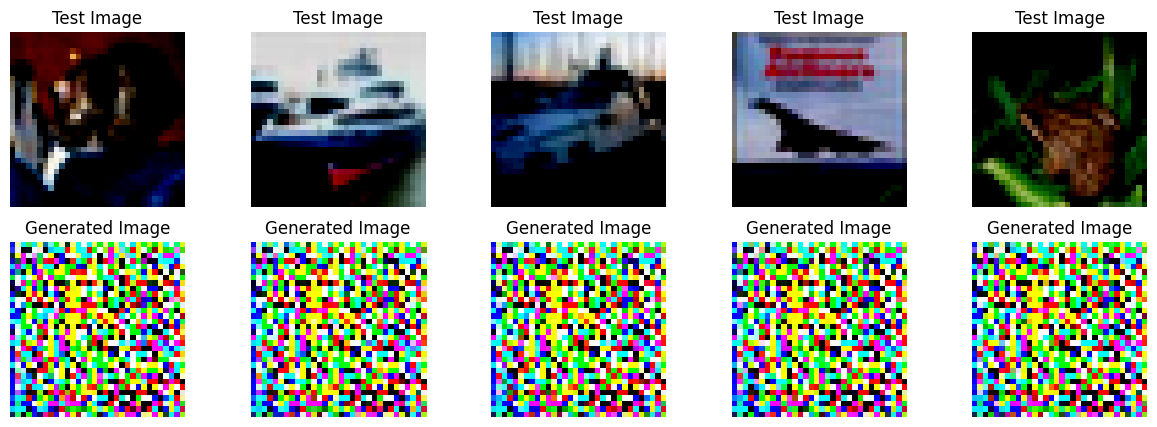

In [14]:
import matplotlib.pyplot as plt

# Load the images from the test data and generated images
test_images = X_test[:5]  # Assuming X_test contains the test images
noise = np.random.normal(0, 1, (5, latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5

# Display 5 images from the test data
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('Test Image')
    plt.axis('off')

# Display 5 images generated by the generator
for i in range(5):
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(generated_images[i])
    plt.title('Generated Image')
    plt.axis('off')

plt.show()


The generated images are not of good quality . They are blurred and only pixels are arranged.